# Pytorch Custom Datasets

In [1]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Get Data

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directoryy already exists...")
else:
  print(f"{image_path} does not exist")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza, steak, sushi data...")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing an image

data/pizza_steak_sushi/train/steak/2881783.jpg
steak
512 512


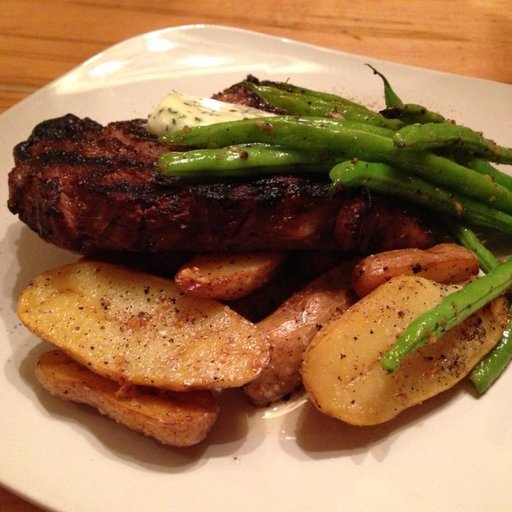

In [7]:
import random
from PIL import Image

# random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)
print(img.height, img.width)
img

(-0.5, 511.5, 511.5, -0.5)

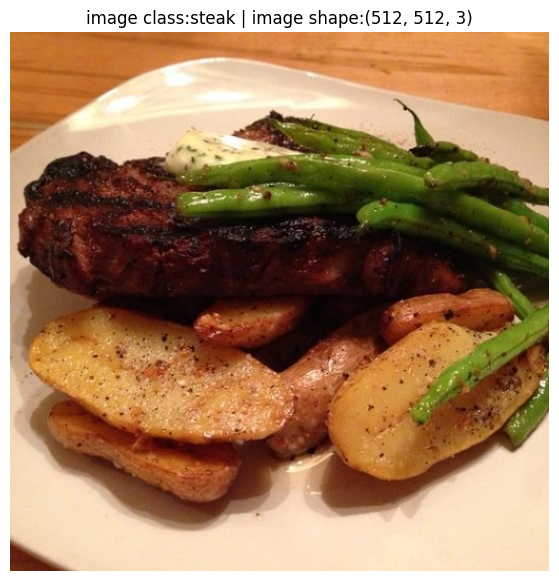

In [8]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"image class:{image_class} | image shape:{img_as_array.shape}")
plt.axis(False)

## 3. Transforming data

In [9]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [10]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

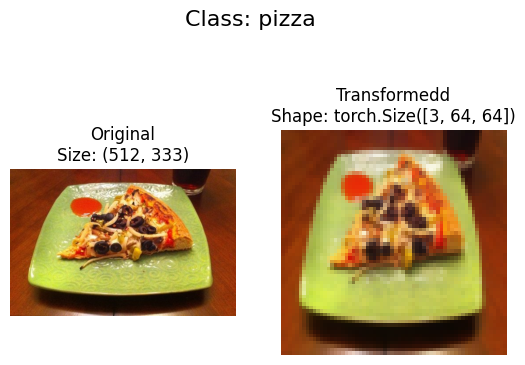

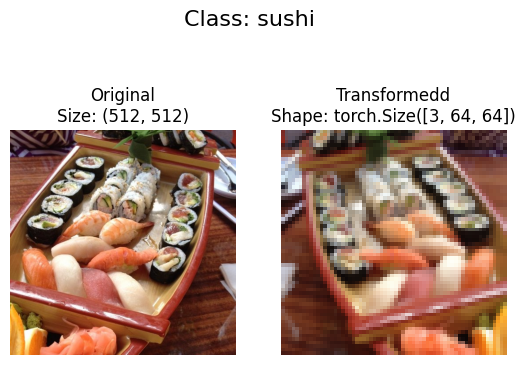

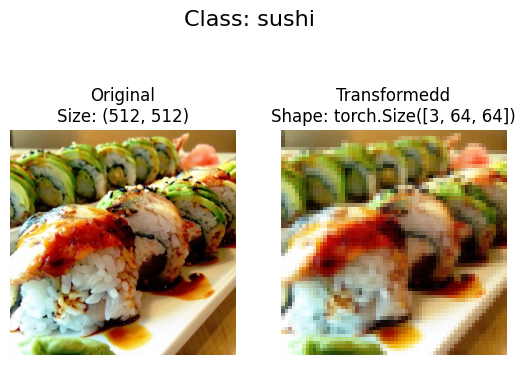

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f)
      ax[1].imshow(transformed_image.permute(1,2,0))
      ax[1].set_title(f"Transformedd\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

In [13]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
image, label = train_data[0]
image.shape, image.dtype, label, type(label)

(torch.Size([3, 64, 64]), torch.float32, 0, int)

(torch.Size([64, 64, 3]), torch.Size([3, 64, 64]))

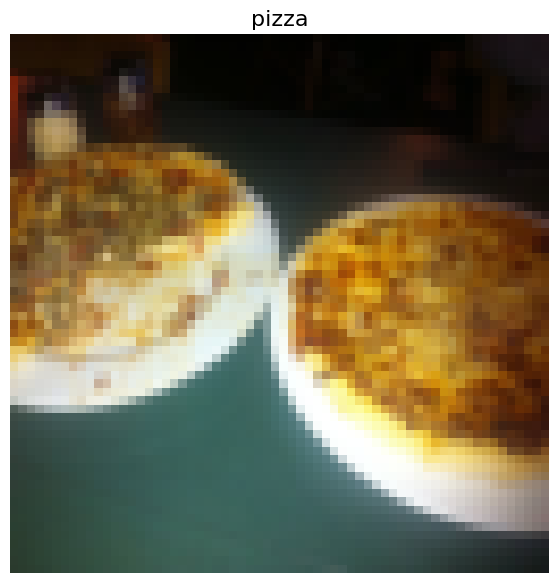

In [17]:
image_permute = image.permute(1, 2, 0)
plt.figure(figsize=(10, 7))
plt.imshow(image_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=16)
image_permute.shape, image.shape

## 4.1 Turn loaded images into `DataLoader`

In [18]:
os.cpu_count()

2

In [19]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e02571e6e00>,
 <torch.utils.data.dataloader.DataLoader at 0x7e02571e6da0>)

In [20]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [21]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 5. Loading Image Data with a custom `Dataset`

In [22]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


### 5.1 Creating a helper function to get class names

In [23]:
target_directory = train_dir

# Get the class names from the target directory
class_names_found = sorted(entry.name for entry in list(os.scandir(target_directory)))
class_names_found

['pizza', 'steak', 'sushi']

In [24]:
def find_classes(directory: str) ->Tuple[List[str], Dict[str, int]]:
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... Please check file structure.")

  # 2. Create a dictionary of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [25]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx




In [26]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
len(train_data), len(train_data_custom)

(225, 225)

In [28]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.3 Create a function to display random images

In [29]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print(f"n shoudnt' be larger than 10")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
    print(dataset[targ_sample][1])
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape:{targ_image_adjust.shape }"
    plt.title(title)


2
0
0
2
0


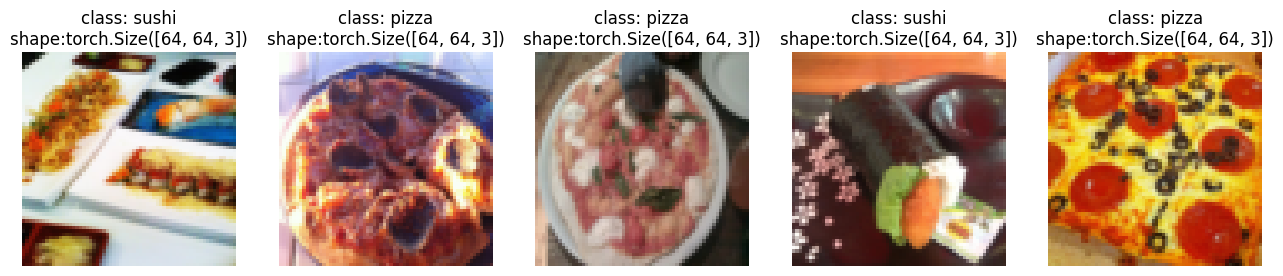

In [30]:
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

0
2
2
0
2


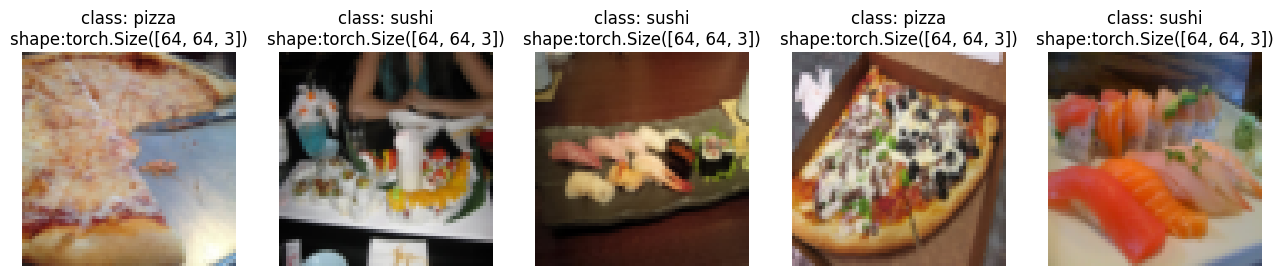

In [31]:
display_random_images(dataset=train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=42)

### 5.4 Turn custom loaded images into DataLoader's

In [32]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=os.cpu_count())

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=os.cpu_count())

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7e025656dcc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e0257032980>)

In [33]:
img, label = next(iter(train_dataloader_custom))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. data augmentation

In [34]:
# trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [35]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/sushi/479711.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2385731.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1245193.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1230335.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/887831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/343036.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/1600999.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2276986.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/2741434.jpg'),
 PosixPath('data/pizza_steak_sushi/test/sushi/3806282.jpg')]

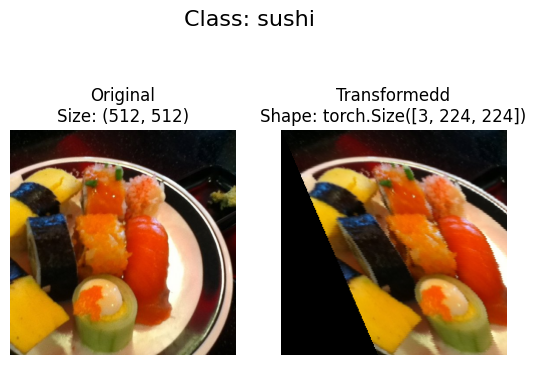

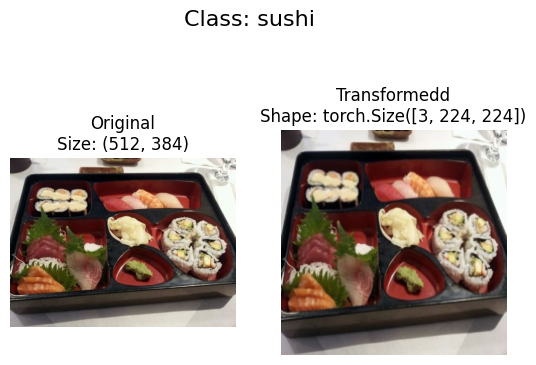

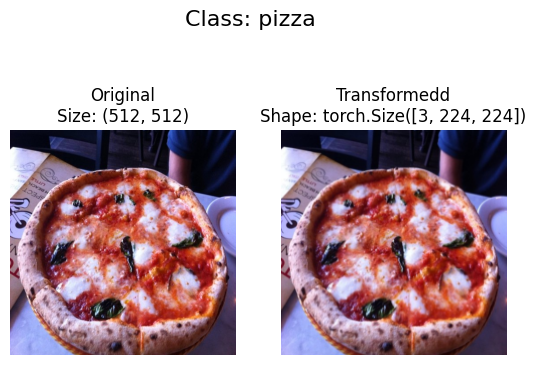

In [36]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data Model 0

In [41]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import os

BATCH_SIZE=32

train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(root=train_dir,
                         transform=train_transform)
test_dadta = datasets.ImageFolder(root=test_dir,
                         transform=test_transform)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=os.cpu_count())



### 7.2 Create TinyVGG model class

In [51]:
from torch import nn
import torch

class TinyVggModelV0(nn.Module):
  def __init__(self,
               input_shape,
               hidden_units,
               output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),

        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 16 * 16,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    print(x.shape)
    x = self.classifier(x)
    return x


In [54]:

torch.manual_seed(42)

model_0 = TinyVggModelV0(input_shape=3,
                         hidden_units=10,
                         output_shape=3).to(device)
model_0

TinyVggModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [55]:
rand_img = torch.randn(size=(1, 3, 64, 64))
model_0(rand_img)

torch.Size([1, 10, 16, 16])


tensor([[0.1101, 0.1035, 0.0715]], grad_fn=<AddmmBackward0>)